In [2]:
"""
unsup_tep.py
****
Finds square-like similarity matrix from pre-extrated features from 3D CNN model.
"""
# %%
# import things
import numpy as np
from tqdm import tqdm
from os.path import join
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import argparse
import pickle
import copy
from itertools import combinations
%matplotlib inline

In [3]:
parser = argparse.ArgumentParser(description='COMPOSITE EVENTS GENERATION')

parser.add_argument('--feat_path', type=str, default="datasets/3d_feat/4_3min_feat", help='3D-CNN features path')
parser.add_argument('--vid_length', type=int, default=25, help='number of video length in feature path, [1: 28, 2: 25, 3: 24, 4: 25, 5: 24]')
parser.add_argument('--output_fname', type=str, default="4_3min", help='output file name')
parser.add_argument('--clustering_trials', type=int, default=6, help='number of clustering trials for atomic event generation' )

args = parser.parse_args(args=[])

In [4]:
# bunch of functions
# cosine similarity
def cos_sim_mat(test_feat):
    """
    returns cosine similarity matrix of given vectors.
    """
    dist_out = 1-pairwise_distances(test_feat, metric="cosine")
    return dist_out


# 1D pca function
def pca1(input_mat):
    """
    does 1D-PCA on given vectors.
    the vectors shoulbe be in shape of (num_samples, num_features)
    returns:
        - 1D-PCA result of given vectors.
    """
    pca = PCA(n_components=1,whiten=True)
    pca_ed = np.squeeze(pca.fit_transform(input_mat))
    return pca_ed

# diagonal matrix function
def get_diagonal_matrix(ref_mat,thickness=1):
    """
    makes diagonal identity matrix of custom thickness
    args:
        - ref_mat: reference square matrix. the output will be the same shape with ref_mat.
        - thickness: thickness of diagonal matrix
    returns:
        - identity matrix of shape ref_mat.shape, thickness of "thickness" arg.
    """
    diag_mat = np.identity(ref_mat.shape[0])
    for i in range(1,thickness):
        id_mat = np.identity(ref_mat.shape[0])
        right_mat = np.concatenate([id_mat[i:],np.zeros([i,*id_mat.shape[1:]])])
        left_mat = np.concatenate([np.zeros([i,*id_mat.shape[1:]]),id_mat[:-i]])
        diag_mat += right_mat
        diag_mat += left_mat
    return diag_mat

def center_cleansing(mat,clean_thickness=2,avg_length=2):
    """
    make diagonal elements of given matrix smooth, 
    by replacing their values with weighted-mean(adjcent elements)
    (not used now)
    """
    center_mask = get_diagonal_matrix(mat,clean_thickness)
    avg_mask = get_diagonal_matrix(mat,clean_thickness+avg_length)
    avg_mask = avg_mask - center_mask
    avg_sums =  np.mean(mat * avg_mask,axis=1)
    avg_cnts = np.mean(avg_mask > 1e-5,axis=1)
    avg_values = avg_sums / avg_cnts
    center_values = center_mask * np.expand_dims(avg_values,axis=1)
    new_mat = np.array(mat)
    new_mat[center_mask > 1e-5] = 0.0
    new_mat += center_values
    return new_mat

def mat_thresh(mat):
    """
    adaptively threshold given matrix.
    The threshold value is determined by
    (mean(mat) + 1.0) / 2
    """
    avg_val = np.mean(mat)
    avg_thresh = (avg_val + 1) / 2
    new_mat = np.array(mat)
    new_mat[mat>avg_thresh] = avg_thresh
    return new_mat

def kmeans_clustering(mat,time_scale=1,n_clusters=5):
    """
    Does k-means clustering, but attaches relative timestamp as feature of input vector to encourage the resulting classes time-related.
    the input vectors shoulbe be in shape of (num_samples, num_features).
    args:
        - mat: input vectors. shoulbe be in shape of (num_samples, num_features).
        - time_scale: the weight applied to time feature.
        - n_clusters: number of k-means clusters
    """
    mat_length = mat.shape[0]
    timestamps = np.expand_dims(np.linspace(start=0,stop=time_scale,num=mat_length),axis=1)
    mat_with_timestamps = np.concatenate([mat,timestamps],axis=1)
    kmeans = KMeans(n_clusters=n_clusters,tol=1e-5,max_iter=400, random_state=1234)
    kmeans_classes = kmeans.fit_predict(mat_with_timestamps)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_centers = np.array(kmeans_centers)
    return kmeans_classes, kmeans_centers

def flatten_class(class_sequence,window_size=5):
    """
    tries to remove sudden incorrect occurances(noisy labels) by smoothing out the class sequence.
    does sliding window, that selects most frequent element in the window.
    args:
        - class_sequence: the sequence of k-means classes. this is an output of [kmens_clustering] function.
        - window_size: sliding window size. should be odd.
    """
    radius = window_size // 2
    flattened_sequence = np.array(class_sequence)
    for center in range(len(class_sequence)):
        close_elements = class_sequence[max(0,center-radius):min(center+radius,len(class_sequence))]
        most_frequent_class = np.argmax(np.bincount(close_elements))
        flattened_sequence[center] = most_frequent_class
    return flattened_sequence

def merge_classes(class_sequence,kmeans_centers,thresh=0.996):
    """
    given k-means results (class sequence and cluster centers), 
    merge classes that have too close centers.
    args:
        - class_sequence: the sequence of k-means classes. I recommand using the output of [flatten_class] fuction
        - kmeans_centers: the center vector k-means clustering. i.e. an output of [kmeans_clustering] function.
        - thresh: merging threshold of class center similarity (metric: cosine similarity)
    returns:
        - class sequence with merged classes
    """
    num_classes = kmeans_centers.shape[0]
    class_counts = np.bincount(class_sequence)
    class_similarity = cos_sim_mat(kmeans_centers) - np.identity(num_classes)
    for i in range(num_classes):
        for j in range(i+1,num_classes):
            if class_similarity[i,j] > thresh:
                if class_counts[i] >= class_counts[j]:
                    class_sequence[class_sequence == j] = i
                else:
                    class_sequence[class_sequence == i] = j
    return class_sequence

def get_transition_sites(class_sequence):
    """
    given class sequcne, finds transition sites.
    args:
        - class_sequence: the sequence of k-means classes. I recommand using the output of [merge_classes] function
    """
    current_class = class_sequence[0]
    transition_sites = []
    transition_sites.append(0)
    for i,val in enumerate(class_sequence):
        if val != current_class:
            current_class = val
            transition_sites.append(i)
    transition_sites.append(len(class_sequence))
    return transition_sites

def remove_short_transition(transition_sites,thresh=11):
    """
    removes transitions that are too close from others.
    """
    if len(transition_sites) < 4:
        return transition_sites
    for i in range(len(transition_sites) - 1):
        forward_difference = transition_sites[i+1] - transition_sites[i]
        if forward_difference <= thresh:
            transition_sites[i] = transition_sites[-1]
    transition_sites.append(0)
    transition_sites = list(set(transition_sites))
    transition_sites = sorted(transition_sites)
    return transition_sites

In [4]:
vid_list = [str(i+1) for i in range(args.vid_length)]

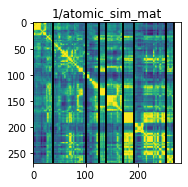

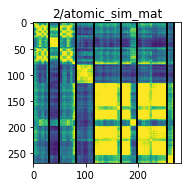

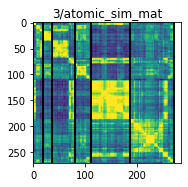

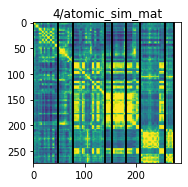

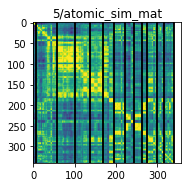

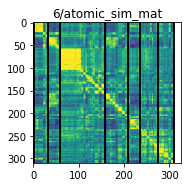

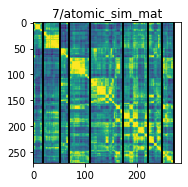

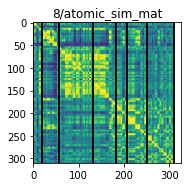

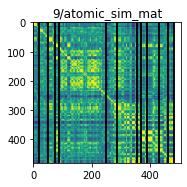

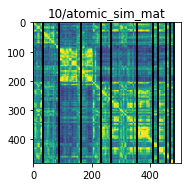

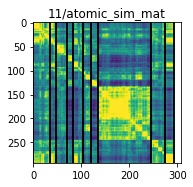

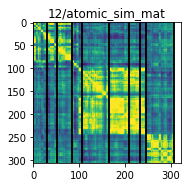

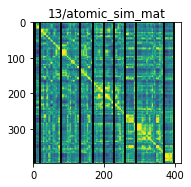

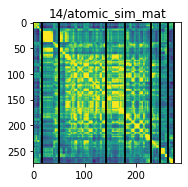

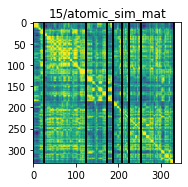

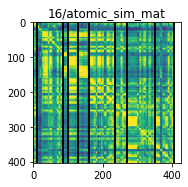

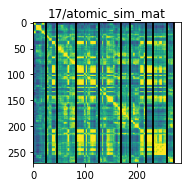

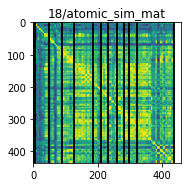

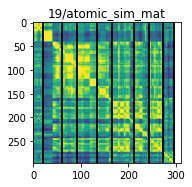

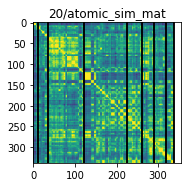

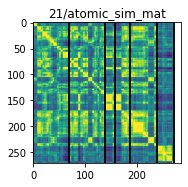

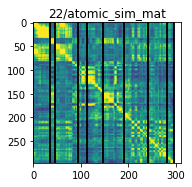

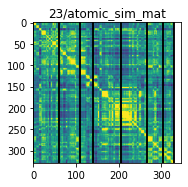

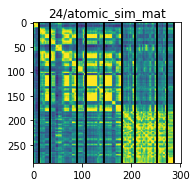

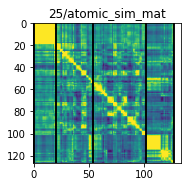

In [5]:
# ATOMIC EVENT VISUALIZATION
# show demo

for i in range(args.vid_length):
    vid = str(i+1)
    vid_feat = np.load(join(args.feat_path, vid+".npy"))
    feat_len = vid_feat.shape[0]
    sim_mat = cos_sim_mat(vid_feat)
    another_sim_mat = mat_thresh(sim_mat)
    max_points = 0
    top_transition_sites = None
    for j in range(args.clustering_trials):
        kmeans_classes, kmeans_centers = kmeans_clustering(another_sim_mat)
        kmeans_classes = merge_classes(kmeans_classes,kmeans_centers)
        kmeans_classes = flatten_class(kmeans_classes)
        transition_sites = get_transition_sites(kmeans_classes)
        transition_sites = remove_short_transition(transition_sites)
        if len(transition_sites) > max_points:
            max_points = len(transition_sites)
            top_transition_sites = transition_sites
    # draw sim mat
    fig = plt.figure(num=3,figsize=(9,3))
    # draw thresholded version
    fig.add_subplot(1,3,1)
    plt.imshow(another_sim_mat)
    for t in top_transition_sites:
        plt.axvline(t,color='k')
    plt.title("{}/atomic_sim_mat".format(vid))
    for t in top_transition_sites:
        plt.axvline(t,color='k')
    plt.show()

In [6]:
# ATOMIC EVENT generation

transition_dict = {}
for vid in tqdm(vid_list):
    # load vid feature and make similarity matrix
    vid_feat = np.load(join(args.feat_path, vid+".npy"))
    sim_mat = cos_sim_mat(vid_feat)
    sim_mat = mat_thresh(sim_mat)
    # clustering
    max_points = 0
    for i in range(args.clustering_trials):
        kmeans_classes, kmeans_centers = kmeans_clustering(sim_mat)
        kmeans_classes = merge_classes(kmeans_classes,kmeans_centers)
        kmeans_classes = flatten_class(kmeans_classes)
        transition_sites = get_transition_sites(kmeans_classes)
        transition_sites = remove_short_transition(transition_sites)
        transition_sites = [x / vid_feat.shape[0] for x in transition_sites]
        # update if found more lines than previous best
        if len(transition_sites) > max_points:
            max_points = len(transition_sites)
            transition_dict[vid] = transition_sites

100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


In [7]:
# ATOMIC EVENT save
atomic_output_fname = 'atomic_events_' + args.output_fname + '.pickle'
with open(join('datasets/atomic_events', atomic_output_fname), 'wb') as f:
    pickle.dump(transition_dict, f)

In [8]:
# COMPOSITE EVENT generation & save
with open(join('datasets/atomic_events', atomic_output_fname), 'rb') as f:
    atomic_event = pickle.load(f)

composite_event_dict = {}
for k, v in atomic_event.items():
    comp_event = []
    for i in list(combinations(v, 2)):
        comp_event.append(i)
    composite_event_dict[k] = copy.deepcopy(comp_event)

In [9]:
# COMPOSITE EVENT save
comp_output_fname = 'composite_events_' + args.output_fname + '.pickle'
with open(join('datasets/composites_events', comp_output_fname), 'wb') as f:
    pickle.dump(composite_event_dict, f)

## Evaluate AR@AN (=20)

!python evaluate.py --comp_event datasets/composites_events/composite_events_1_3min.pickle --gt_file datasets/composites_events/gt_1_3min.pickle <br><br>
Result: For 1 video: AR@AN (=20):34.54 <br><br>

!python evaluate.py --comp_event datasets/composites_events/composite_events_2_3min.pickle --gt_file datasets/composites_events/gt_2_3min.pickle <br><br><br>
Result: For 1 video: AR@AN (=20):27.38 <br><br>

!python evaluate.py --comp_event datasets/composites_events/composite_events_3_3min.pickle --gt_file datasets/composites_events/gt_3_3min.pickle <br><br><br>
Result: For 1 video: AR@AN (=20):32.04 <br><br>

!python evaluate.py --comp_event datasets/composites_events/composite_events_4_3min.pickle --gt_file datasets/composites_events/gt_4_3min.pickle <br><br><br>
Result: For 1 video: AR@AN (=20):32.53 <br><br>

!python evaluate.py --comp_event datasets/composites_events/composite_events_5_3min.pickle --gt_file datasets/composites_events/gt_5_3min.pickle <br><br><br>
Result: For 1 video: AR@AN (=20):39.38 <br><br>

Total Average: 33.08

In [10]:
!python evaluate.py --comp_event datasets/composites_events/composite_events_1_3min.pickle --gt_file datasets/composites_events/gt_1_3min.pickle

[0.57731959 0.54639175 0.5257732  0.44329897 0.39175258 0.34020619
 0.27835052 0.19587629 0.11340206 0.04123711]
AVERAGE RECALL @ 20:  0.34536082474226804


In [11]:
!python evaluate.py --comp_event datasets/composites_events/composite_events_2_3min.pickle --gt_file datasets/composites_events/gt_2_3min.pickle

[0.46601942 0.41747573 0.39805825 0.34951456 0.32038835 0.25242718
 0.2038835  0.15533981 0.10679612 0.06796117]
AVERAGE RECALL @ 20:  0.2737864077669903


In [12]:
!python evaluate.py --comp_event datasets/composites_events/composite_events_3_3min.pickle --gt_file datasets/composites_events/gt_3_3min.pickle

[0.53763441 0.50537634 0.44086022 0.39784946 0.3655914  0.31182796
 0.2688172  0.19354839 0.11827957 0.06451613]
AVERAGE RECALL @ 20:  0.3204301075268817


In [13]:
!python evaluate.py --comp_event datasets/composites_events/composite_events_4_3min.pickle --gt_file datasets/composites_events/gt_4_3min.pickle

[0.59770115 0.57471264 0.45977011 0.4137931  0.40229885 0.32183908
 0.24137931 0.14942529 0.10344828 0.05747126]
AVERAGE RECALL @ 20:  0.33218390804597697


In [14]:
!python evaluate.py --comp_event datasets/composites_events/composite_events_5_3min.pickle --gt_file datasets/composites_events/gt_5_3min.pickle

[0.67692308 0.66153846 0.6        0.50769231 0.46153846 0.36923077
 0.26153846 0.21538462 0.13846154 0.04615385]
AVERAGE RECALL @ 20:  0.39384615384615385
